In [1]:
# imports
#bigqueryhelper
from google.cloud import bigquery
import pandas as pd
import numpy as np
import plotly
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
conda list python -f

# packages in environment at /Users/davidhofhuizen/opt/anaconda3:
#
# Name                    Version                   Build  Channel
python                    3.7.13               hdfd78df_0  

Note: you may need to restart the kernel to use updated packages.


In [3]:
# API key verification for Google Cloud
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/Users/davidhofhuizen/Projects/EDA_Bitcoin-ledger/rugged-ether-350608-2a8031aeb288.json"
client = bigquery.Client()

Functions

In [4]:
def run_query(query):
    query_job = client.query(query)

    iterator = query_job.result(timeout=120)
    rows = list(iterator)

    # Transform the rows into a nice pandas dataframe
    result = pd.DataFrame(data=[list(x.values()) for x in rows], columns=list(rows[0].keys()))
    
    return result

In [5]:

def estimate_gigabytes_scanned(query, bq_client):
    """A useful function to estimate query size. 
    Originally from here: https://www.kaggle.com/sohier/beyond-queries-exploring-the-bigquery-api/
    """
    # We initiate a `QueryJobConfig` object
    # API description: https://googleapis.dev/py/bigquery/latest/generated/google.cloud.bigquery.job.QueryJobConfig.html
    my_job_config = bigquery.job.QueryJobConfig()
    
    # We turn on 'dry run', by setting the `QueryJobConfig` object's `dry_run` attribute.
    # This means that we do not actually run the query, but estimate its running cost. 
    my_job_config.dry_run = True

    # We activate the job_config by passing the `QueryJobConfig` to the client's `query` method.
    my_job = bq_client.query(query, job_config=my_job_config)
    
    # The results comes as bytes which we convert into Gigabytes for better readability
    BYTES_PER_GB = 2**30
    estimate = my_job.total_bytes_processed / BYTES_PER_GB
    
    print(f"This query will process {estimate} GBs.")

def balance_transform(value):
    return value / 100000000

Task at hand
- From 2009 to 2015, get all top 100 balannces from these years.
- The balances of these users will be used for time series analysis of transactions over time

In [6]:
def extract_data(year):
    year = int(year + 1)
    previous_year = year - 1
    
    # Query
    wealth_development = f"""
    WITH double_entry_book AS (
    -- debits
    SELECT array_to_string(inputs.addresses, ",") as address, inputs.type, -inputs.value as value, DATE(block_timestamp) as date
    FROM `bigquery-public-data.crypto_bitcoin.inputs` as inputs
    UNION ALL
    -- credits
    SELECT array_to_string(outputs.addresses, ",") as address, outputs.type, outputs.value as value, DATE(block_timestamp) as date
    FROM `bigquery-public-data.crypto_bitcoin.outputs` as outputs
    )
    SELECT address, type, sum(value) as balance, date, EXTRACT(YEAR FROM date) as year
    FROM double_entry_book
    WHERE date < '{year}-01-01'
    GROUP BY date, address, type
    ORDER BY balance DESC
    """

    # Extract data
    df = run_query(wealth_development)
    
    return df



In [7]:
def extract_data2(year):
    year = int(year + 1)
    previous_year = year - 1
    
    # Query
    wealth_development = f'''
    WITH double_entry_book AS (
   -- debits
   SELECT array_to_string(inputs.addresses, ",") as address, inputs.type, -inputs.value as value, DATE(block_timestamp) as date
   FROM `bigquery-public-data.crypto_bitcoin.inputs` as inputs
   WHERE DATE(block_timestamp) < '{year}-01-01'
   UNION ALL
   -- credits
   SELECT array_to_string(outputs.addresses, ",") as address, outputs.type, outputs.value as value, DATE(block_timestamp) as date
   FROM `bigquery-public-data.crypto_bitcoin.outputs` as outputs
   WHERE DATE(block_timestamp) BETWEEN '{previous_year}-01-01' AND '{year}-01-01'
    )
    SELECT address, type, sum(value) as balance
    FROM double_entry_book
    GROUP BY address, type
    ORDER BY balance DESC
    LIMIT 200
    '''

    # Extract data
    df = run_query(wealth_development)
    
    return df



In [8]:
def preprocess(original_df, year):
    df = original_df.copy()

    # make sure all balance changes occur in given year
    df = df[df['year'] == year]
    

    #Group by balance
    df['balance'] = df['balance'].astype('float')
    df = df.groupby(['address', 'type', 'year']).sum('balance').sort_values(by ='balance', ascending = False).head(100).reset_index()


    return df

In [9]:
def Main():

    years = list(range(2009,2016))
    
    for year in years:
        df = extract_data2(year)
        #df = preprocess(df, year)

        df.to_csv(f'Top200_{year}.csv')
        print(f'Year {year} done')

    
    return True

In [10]:
Main()

Year 2009 done
Year 2010 done
Year 2011 done
Year 2012 done
Year 2013 done
Year 2014 done
Year 2015 done


True

In [11]:
def get_addresses(years):
    #address_list = pd.DataFrame(columns = ['address'])
    address_list = []

    for year in years:
        

        df = pd.read_csv(f'Top200_{year}.csv')
        addresses = list(df['address'])

        address_list.extend(addresses)

    address_list = list(set(address_list))

    return address_list
        


In [12]:
early_adopters = tuple(get_addresses(list(range(2009,2016))))

In [13]:
len(early_adopters)

1377

In [14]:
with open('early_adoptersv2.txt', 'w') as filehandle:
    for listitem in early_adopters:
        filehandle.write('%s\n' % listitem)

In [15]:
adopters2009 = tuple(get_addresses([2009]))

In [16]:
def get_transactions(adopters):
    wealth_development = f"""
    WITH double_entry_book AS (
   -- debits
   SELECT array_to_string(inputs.addresses, ",") as address, inputs.type, -inputs.value as value, DATE(block_timestamp) as date
   FROM `bigquery-public-data.crypto_bitcoin.inputs` as inputs
   UNION ALL
   -- credits
   SELECT array_to_string(outputs.addresses, ",") as address, outputs.type, outputs.value as value, DATE(block_timestamp) as date
   FROM `bigquery-public-data.crypto_bitcoin.outputs` as outputs
    )
    SELECT address, type, sum(value) as balance, date, EXTRACT(YEAR FROM date) as year
    FROM double_entry_book
    where address IN {adopters}
    GROUP BY date, address, type
    ORDER BY balance DESC
    """

    df = run_query(wealth_development)

    return df


In [17]:
def get_balance_per_adopter(df):
    balance_per_adopter = df.groupby('address').sum().drop('year', axis =1).reset_index().sort_values(by = 'balance', ascending = False)

    return balance_per_adopter


In [18]:
def adopters_per_year(years):
    df_list = []

    for year in years:
    
        df = pd.read_csv(f'Top200_{year}.csv')
        addresses = tuple(df['address'])

        transactions = get_transactions(addresses)

        transactions['year'] = year
        df_list.append(transactions)

    return pd.concat(df_list, ignore_index=True).sort_values(by='date')
        

In [19]:
adopters_grouped = adopters_per_year(list(range(2009,2016)))

In [20]:
adopters_grouped.to_csv('adopters_grouped.csv')

In [21]:
#adopters_grouped = pd.read_csv('early_adopters_by_yearv2.csv')
#adopters_grouped2 = pd.read_csv('adopters_grouped2.csv')

#all_adopters = pd.concat([adopters_grouped, adopters_grouped2], ignore_index=True)

In [22]:
# Draw Plot
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Balance', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.ticklabel_format(useOffset=False, style='plain')
    plt.plot(df[x], df[y], color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

In [23]:
early_adopter_transactions = get_transactions(early_adopters)

In [24]:
def transaction_processing(df_old):
    df = df_old.copy()

    df['balance'] = df['balance'].astype('int')
    df['date'] = pd.to_datetime(df['date'])
    df['balance'] = df['balance'].apply(balance_transform)
    
    return df

In [25]:
early_adopter_transactions_processed = transaction_processing(early_adopter_transactions)

In [26]:
early_adopter_transactions.to_csv('All_transactions_early_adopters.csv')

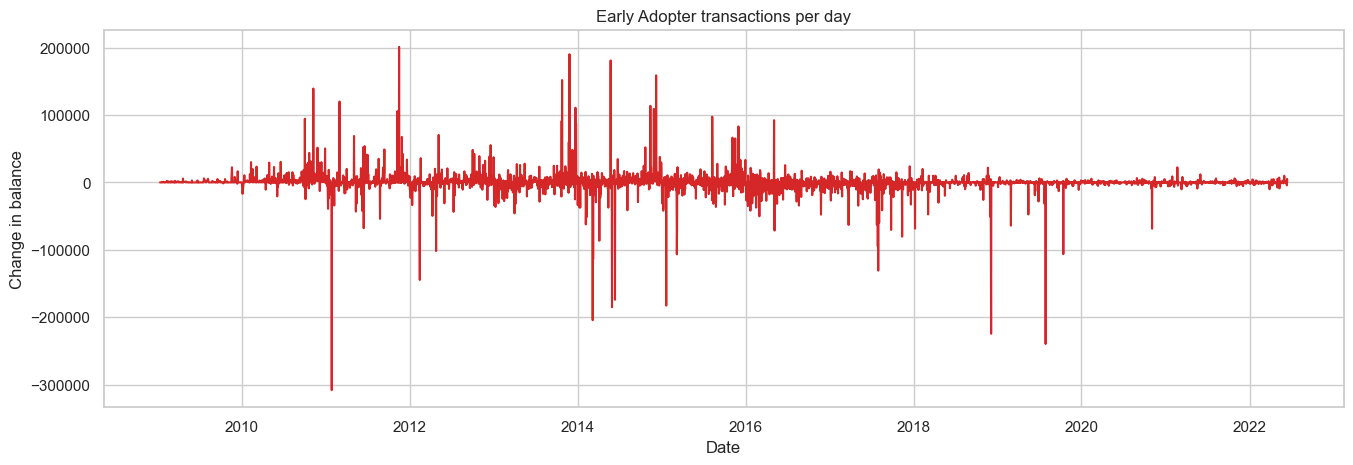

In [27]:
transactions_over_time = early_adopter_transactions_processed[['date', 'balance']].groupby('date').sum().reset_index()
plot_df(transactions_over_time, 'date', 'balance', title="Early Adopter transactions per day", xlabel='Date', ylabel='Change in balance', dpi=100)

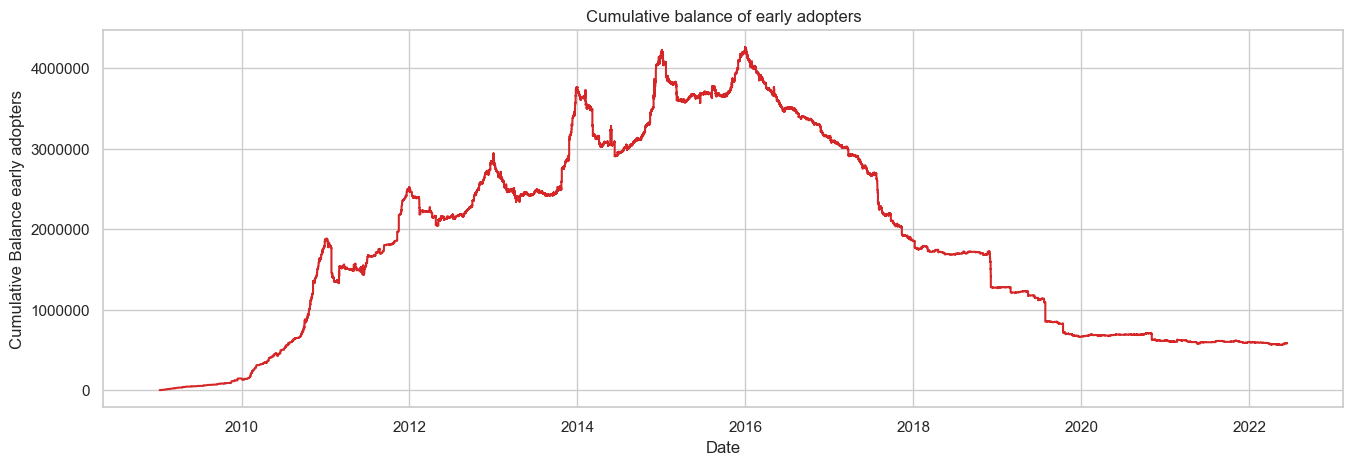

In [28]:
cumulative_balance_over_time = early_adopter_transactions_processed.copy()[['date', 'balance']].sort_values(by= 'date')
cumulative_balance_over_time['cumulative_balance'] = cumulative_balance_over_time['balance'].cumsum()

plot_df(cumulative_balance_over_time, 'date', 'cumulative_balance', title="Cumulative balance of early adopters", xlabel='Date', ylabel='Cumulative Balance early adopters', dpi=100)

In [36]:
early_adopter_transactions_processed['year'] = early_adopter_transactions_processed['date'].apply(lambda x: x.year)

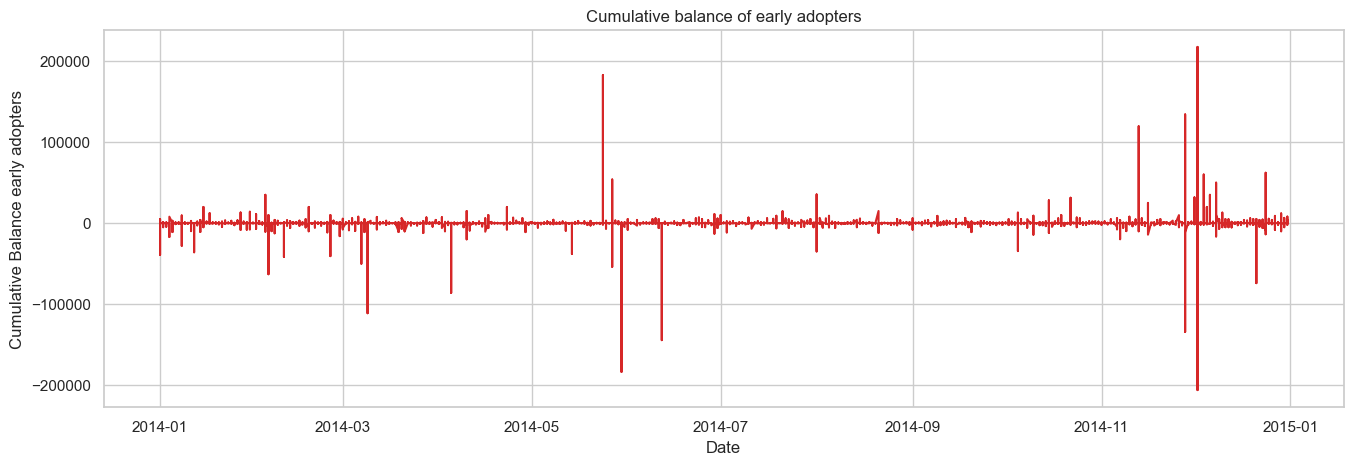

In [44]:
cumulative_balance_over_time_2014 = early_adopter_transactions_processed[early_adopter_transactions_processed['year'] == 2014].sort_values(by= 'date')
cumulative_balance_over_time_2014['cumulative_balance'] = cumulative_balance_over_time_2014['balance'].cumsum()
plot_df(cumulative_balance_over_time_2014, 'date', 'balance', title="Cumulative balance of early adopters", xlabel='Date', ylabel='Cumulative Balance early adopters', dpi=100)

In [43]:
cumulative_balance_over_time_2013[cumulative_balance_over_time_2013['balance'] > 125000]

,address,type,balance,date,year,cumulative_balance
2,1FfmbHfnpaZjKFvyi1okTjJJusN455paPH,pubkeyhash,144336.397,2013-10-25,2013,-138444.721


In [29]:
def plot_grouped_adopters(df):

    df['cumulative_balance'] = df.groupby('year')['balance'].cumsum()

    # key gives the group name (i.e. category), data gives the actual values
    fig, ax = plt.subplots(figsize=(32,10))
    plt.ticklabel_format(useOffset=False, style='plain')
    plt.title("Cumulative balance of early adopters grouped by year")
    plt.ylabel("Balance")
    plt.xlabel("Date")

    for key, data in df.groupby('year'):
        data.plot(x='date', y='cumulative_balance', ax=ax, label=key)

    return True

In [30]:
adopters_grouped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65338 entries, 147 to 34985
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   address  65338 non-null  object
 1   type     65338 non-null  object
 2   balance  65338 non-null  object
 3   date     65338 non-null  object
 4   year     65338 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 3.0+ MB


True

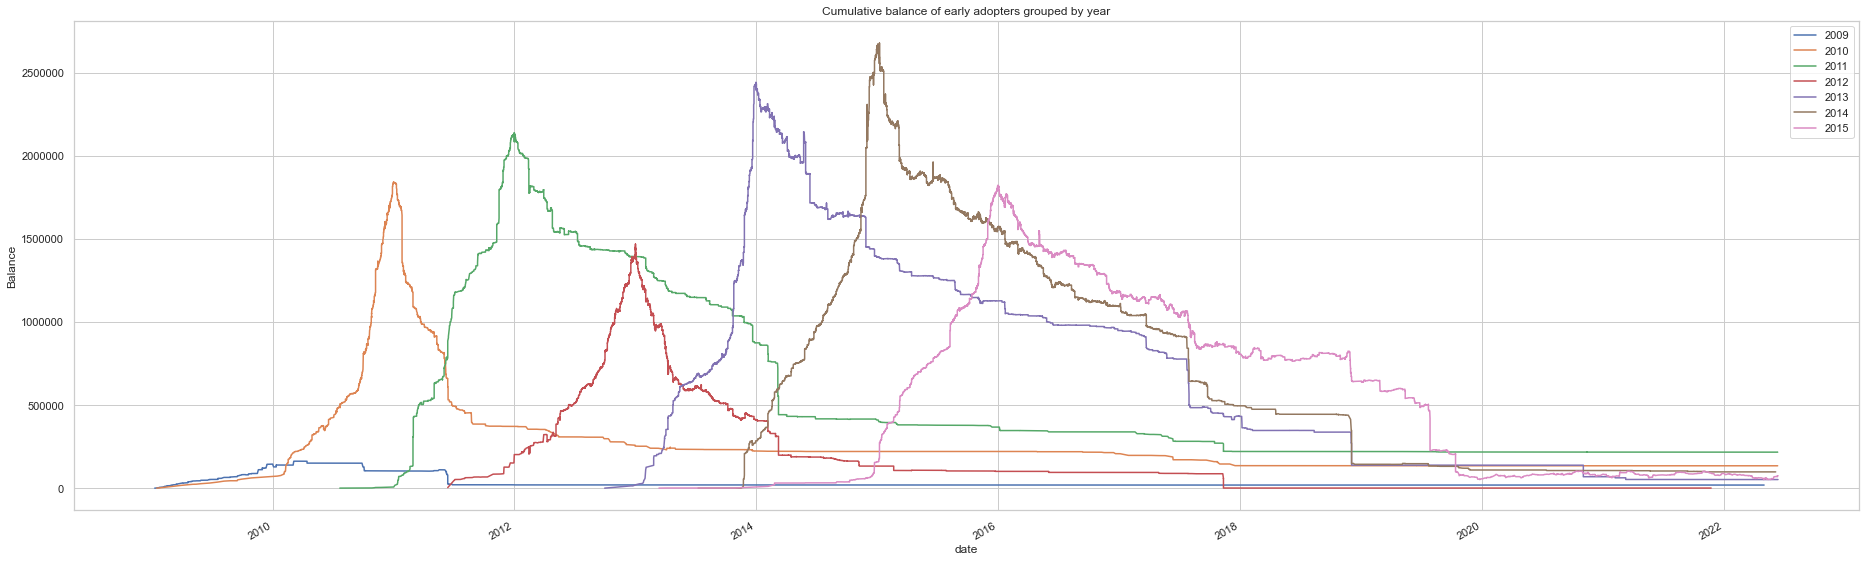

In [31]:
plot_grouped_adopters(transaction_processing(adopters_grouped))

KeyError: 'date'

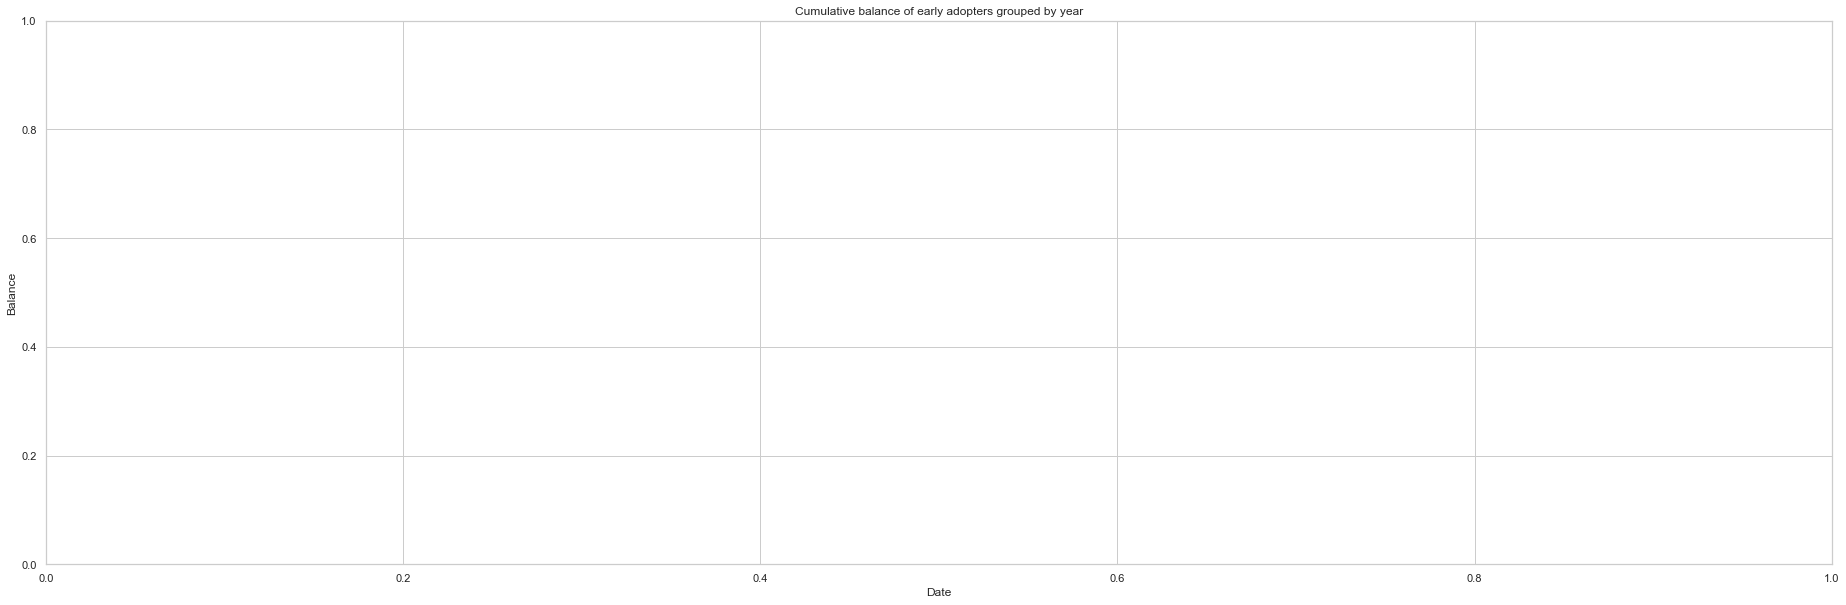

In [32]:
plot_grouped_adopters(early_adopter_transactions_processed.groupby(['year']).sum().groupby(level=0).cumsum().reset_index())

In [ ]:
adopters_grouped.describe()

,Unnamed: 0,balance,year
count,37932.000,37932.000,37932.000
mean,18965.500,1039591061.722,2013.022
std,10950.170,491420810228.945,1.587
min,0.000,-18349740100794.000,2009.000
25%,9482.750,0.000,2012.000
50%,18965.500,275065.000,2013.000
75%,28448.250,12578061966.750,2014.000
max,37931.000,21751763438199.000,2015.000


In [ ]:
adopters_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37932 entries, 0 to 37931
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  37932 non-null  int64 
 1   address     37932 non-null  object
 2   type        37932 non-null  object
 3   balance     37932 non-null  int64 
 4   date        37932 non-null  object
 5   year        37932 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 1.7+ MB


In [ ]:
balance_per_adopter = get_balance_per_adopter(early_adopter_transactions_processed)

In [ ]:
balance_per_adopter.head()

,address,balance
1009,34xp4vRoCGJym3xR7yCVPFHoCNxv4Twseo,252597.235
1308,bc1qgdjqv0av3q56jvd82tkdjpy7gdp9ut8tlqmgrpmv24...,168009.986
896,1P5ZEDWTKTFGxQjZphgWPQUpe554WKDfHQ,127067.534
1226,3LYJfcfHPXYJreMsASk2jkn69LWEYKzexb,116601.137
1298,bc1qazcm763858nkj2dj986etajv6wquslv8uxwczt,94643.299
